In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
dic_cenarios = {
                'V1A1F2 Scenario 2022' : 'D:/0 FERV/0 Dados PYTHON/CASOS 2022_novos/Results/V1A1F2 FNS Lim 2022_corrigidos/',
                # 'MPV Scenario' : 'C:/Users/david/OneDrive/Desktop/FERV codigo/Analise_Estatica/MPV_(FNS Lim)_RC/',
                # 'V2A2F2 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V2A2F2_RESP_FNS_lim_rev2_2026/',
                # 'V2A2F3 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V2A2F3_RESP_FNS_lim_rev1_2026/',
                # # 'V2A2F4 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V2A2F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F3 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # # 'V1A1F4 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V1A1F5_RESP_FNS_lim_rev1_2026/'
                }

dirGeral = 'Data/Geral/'
dirIndice = 'Data/Indice/'
dirRamos = 'Data/Fluxo em Ramos/'
dirPotencia = 'Data/Potencia/'

filenames = [
                # (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                # (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                # (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                # (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 10)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
RegressorML = False
shapValues = False

# Data Processing

In [4]:
def IndiceLinhas(df, n):
    
    df_filtered = df.loc[~(df['L1(MVA)'] == 9999) & df['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].copy()
    # Calculate MW_Flow
    df_filtered.loc[:, 'MW_Flow'] = np.where(df_filtered['MW:From-To'] >= 0, df_filtered['MW:From-To'], df_filtered['MW:To-From'])
    # Calculate PI_mva
    df_filtered.loc[:, 'PI_mva'] = (df_filtered['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df_filtered.groupby(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_r = df_filtered.groupby(['Dia', 'Hora', 'Cenario', 'REG']).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_po = df_filtered.groupby(['Dia', 'Hora', 'Cenario']).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # Calculate PFI
    df_r_nt['PFI'] = df_r_nt['MW_Flow'] / df_r_nt['MVA']
    df_r['PFI'] = df_r['MW_Flow'] / df_r['MVA']
    df_po['PFI'] = df_po['MW_Flow'] / df_po['MVA']

    # Apply PI_mva correction
    df_r_nt['PI_mva'] = df_r_nt['PI_mva'] ** (1 / (2 * n))
    df_r['PI_mva'] = df_r['PI_mva'] ** (1 / (2 * n))
    df_po['PI_mva'] = df_po['PI_mva'] ** (1 / (2 * n))

    return df_r_nt, df_r, df_po

def flatdf(df, BG):
    df_reordered = df.reorder_levels(['Dia','Hora','Cenario','REG',BG])
    regionmap = {'Nordeste':'Northeast', 'Norte':'North', 'Sudeste-Centro-Oeste':'SE-CW', 'Sul':'South','AC-RO':'AC-RO'}
    df_reordered = df_reordered.rename(index=regionmap, level='REG')

    df_reordered_sorted = df_reordered.sort_index(level=['Dia','Hora','Cenario','REG'])
    df_reordered_sorted.rename(columns={'CSI_INF':'DPI_inf', 'CSI_SUP':'DPI_sup'}, inplace=True)
    lista = [[index[0],index[1],index[2]] for index in df_reordered.index]

    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))
    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['Dia','Hora', 'Cenario']
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:,:,:,reg,:].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                if reg == 'Sudeste-Centro-Oeste':
                    reg = 'SE-CO'
                name = column + '_' + reg + '_' + str(bg)
                columns.append(str(name))
    datapd.columns = columns
    return datapd

def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

dfs = read_data()
df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)

def filtarNC(df):
    df_fiiltrado = []
    for df_ in df:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[df_indice_grop['Cenario']==cenario][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = (df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv))
        df_filt = df_[filtro]
        df_fiiltrado.append(df_filt)
    return df_fiiltrado
    
def concatenation_1():

    data = {}
    
    print('====== Començo da concatenação ======')
    ddff1 = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'])
    ddff2 = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'])
    data['df_DPI'] = pd.concat([flatdf(ddff2, 'VBASEKV'), flatdf(ddff1, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat']  = pd.concat(filtarNC(dfs['ger_reg']), axis=0)

    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)
    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Unnamed: 0': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Unnamed: 0': 'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    # data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_hvdc_01 = df_hvdc_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_intercambios_01 = df_intercambios_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([df_hvdc_01.loc[:,:,:,'Elo_FOZ-IBIUNA']['MW:From-To'], df_hvdc_01.loc[:,:,:,'Elo_PVEL-ARARQ']['MW:From-To'], df_hvdc_01.loc[:,:,:,'Elo_XINGU-SE']['MW:From-To'], df_hvdc_01.loc[:,:,:,'Elo_CPVBTB-PVEL']['MW:From-To']], axis=1,keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE', 'Elo_CPVBTB-PVEL'])
    concatenated_FluxoAC = pd.concat([df_intercambios_01.loc[:,:,:,'Fluxo_N-S']['MW:From-To'],df_intercambios_01.loc[:,:,:,'Fluxo_NE-N']['MW:From-To'], df_intercambios_01.loc[:,:,:,'Fluxo_NE-SE']['MW:From-To'], df_intercambios_01.loc[:,:,:,'Fluxo_SUL-SECO']['MW:From-To']], axis=1, keys=['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])
    
    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on =['Dia','Hora','Cenario'], how='left')

    return data

DATA = concatenation_1()
print('====== Calculo do Indice de Carregamento ======')
dfl_r_nt, dfl_r, dfl_po = IndiceLinhas(DATA['df_linhas'],2)

def concatenation_2(data):
    print('====== Començo do processamento ======')
    # =================================================== POR PONTO DE OPERAÇÃO =============================================

    DFF_POT = data['df_ger_reg_concat'].drop(columns=['REG','PG_FERV']).groupby(by=['Dia', 'Hora', 'Cenario']).sum()
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_filtered = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])]
    df_linhas_grouped = df_linhas_filtered.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500up = df_linhas_500up.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500down = df_linhas_500down.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500up = df_linhas_grouped_500up.rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_grouped_500down = df_linhas_grouped_500down.rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    DF_complete_PO = pd.concat([df_linhas_grouped_500up, df_linhas_grouped_500down, df_linhas_grouped], axis=1)
    DF_complete_PO = DF_complete_PO.merge(DFF_POT.groupby(['Dia', 'Hora', 'Cenario']).sum(), on=['Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']] = DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']].fillna(0)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']  # Hasta esta linea son 6 segundos

    # =================================================== POR REGIÃO =========================================================

    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia','Hora','REG','Cenario']).drop(columns='PG_FERV')
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by = ['Dia','Hora','REG','Cenario']).agg({'% L1_Trafo':'mean', 'Mvar:Losses_Trafo':'sum'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(dfl_r[['PI_mva','PFI']], on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    insecure_indices = df_indice_grop[df_indice_grop['DPI_PO_final'] > 1].index
    filtro = df_REG_Cenario_PV.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
    df_Indice_complete_PV_inseguro = df_REG_Cenario_PV[filtro]
    df_Indice_complete_PQ_inseguro = df_REG_Cenario_PQ[filtro]
    df_Indice_complete_PV_alarme = df_REG_Cenario_PV[~filtro]
    df_Indice_complete_PQ_alarme = df_REG_Cenario_PQ[~filtro]
    Df_data_completo_reg = df_Indice_complete_PQ_alarme[['OV DPI', 'UV DPI']].merge(df_Indice_complete_PV_alarme, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    print('====== Fim do processamento ======')

    return Df_data_completo_reg, DF_complete_PO

Df_data_completo_reg, DF_complete_PO = concatenation_2(DATA)

In [7]:
regionmap = {'Nordeste':'Northeast', 'Norte':'North', 'Sudeste-Centro-Oeste':'SE-CW', 'Sul':'South','AC-RO':'AC-RO'}
Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')
print(Df_data_completo_reg.index.get_level_values('Cenario').unique())
print(Df_data_completo_reg.columns)

Index(['Cenario Baixa F2', 'Cenario Baixa F3', 'Cenario Baixa F4',
       'Cenario Baixa F5'],
      dtype='object', name='Cenario')
Index(['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV', 'OV condition',
       'UV condition', '% L1_500up', 'Mvar:Losses_500up', '% L1_500down',
       'Mvar:Losses_500down', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR',
       'Shunt_Ind', 'Shunt_Cap', 'SHUNT_INST_IND', 'SHUNT_INST_CAP',
       'ReservaIND', 'ReservaCAP', 'PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL',
       'PG_BIO', 'PG_Dist', 'QG/QL', 'PG/PL', 'ReservaINDshunt',
       'ReservaCAPshunt', '% L1_Trafo', 'Mvar:Losses_Trafo', 'PI_mva', 'PFI'],
      dtype='object')


In [8]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff
def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux = True, Reserva = False, IndiceGroup = False, DPI = False, InfoPO = False, PImva_reg_nt=False, PImva=False):

    if cenario == 'all':
        df_data_completo = df_data_completo.reorder_levels(['Dia','Hora','Cenario','REG'])[columns]
        if region == 'all':
            df_reordered_sorted = df_data_completo
            lista = [[index[0],index[1],index[2]] for index in df_reordered_sorted.index]
        elif region == 'PO':
            df_reordered_sorted = df_data_completo
        else:
            df_reordered_sorted = df_data_completo.loc[:,:,:,region]
    else:
        df_data_completo = df_data_completo.reorder_levels(['Dia','Hora','Cenario','REG'])[columns]
        if region == 'all':
            df_reordered_sorted = df_data_completo.loc[:,:,cenario,:]
            if type(cenario) == list:
                lista = [[index[0],index[1],index[2]] for index in df_reordered_sorted.index]
            else:
                lista = [[index[0],index[1]] for index in df_reordered_sorted.index]
                
        elif region == 'PO':
            df_reordered_sorted = df_data_completo.loc[:,:, cenario]
        else:
            df_reordered_sorted = df_data_completo.loc[:,:, cenario, region]
    
    if region == 'all':
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns

    #===============================================================================
    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if type(cenario) == list:
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario','REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)
    if ACDCflux:
        if cenario == 'all':
            datapd = datapd.merge(DATA['df_Inter_AC_DC'], on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(DATA['df_Inter_AC_DC'].loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(DATA['df_Inter_AC_DC'].loc[:,:, cenario], on=['Dia', 'Hora'], how='left')
    if Reserva:
        if cenario == 'all':
            datapd = datapd.merge(DATA['df_reserva'], on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(DATA['df_reserva'].loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(DATA['df_reserva'].loc[:,:, cenario], on=['Dia', 'Hora'], how='left')
    if IndiceGroup:
        if cenario == 'all':
            datapd = datapd.merge(DATA['df_indice_group'], on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(DATA['df_indice_group'].loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(DATA['df_indice_group'].loc[:,:, cenario], on=['Dia', 'Hora'], how='left') 
    if DPI:
        if cenario == 'all':
            datapd = datapd.merge(DATA['df_DPI'], on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(DATA['df_DPI'].loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(DATA['df_DPI'].loc[:,:, cenario], on=['Dia', 'Hora'], how='left')
    if PImva:
        if cenario == 'all':
            datapd = datapd.merge(dfl_po[['PI_mva','PFI']], on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(dfl_po[['PI_mva','PFI']].loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(dfl_po[['PI_mva','PFI']].loc[:,:, cenario], on=['Dia', 'Hora'], how='left')
    if PImva_reg_nt:
        dff = flatdf(dfl_r_nt[['PI_mva','PFI']], 'VBASEKV')
        if cenario == 'all':
            datapd = datapd.merge(dff, on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(dff.loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(dff.loc[:,:, cenario], on=['Dia', 'Hora'], how='left')
    if InfoPO:
        columns = ['PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR','PG_FERV','Shunt_Ind','Shunt_Cap','ReservaIND','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL','PG_BIO', 'PG_Dist']
        if cenario == 'all':
            datapd = datapd.merge(DF_complete_PO[columns], on=['Dia', 'Hora', 'Cenario'], how='left') 
        else:
            if type(cenario) == list:
                datapd = datapd.merge(DF_complete_PO[columns].loc[:,:, cenario], on=['Dia', 'Hora', 'Cenario'], how='left') 
            else:
                datapd = datapd.merge(DF_complete_PO[columns].loc[:,:, cenario], on=['Dia', 'Hora'], how='left')

    datapd.columns = datapd.columns.astype(str)
    return datapd

# Explainability of the ML model

In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
shap.initjs()

In [10]:
'''
Index(['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV', 'OV condition',
       'UV condition', '% L1_500up', 'Mvar:Losses_500up', '% L1_500down',
       'Mvar:Losses_500down', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR',
       'Shunt_Ind', 'Shunt_Cap', 'SHUNT_INST_IND', 'SHUNT_INST_CAP',
       'ReservaIND', 'ReservaCAP', 'PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL',
       'PG_BIO', 'PG_Dist', 'QG/QL', 'PG/PL', 'ReservaINDshunt',
       'ReservaCAPshunt', '% L1_Trafo', 'Mvar:Losses_Trafo', 'PI_mva', 'PFI',
       'Cenario Hidrologico'],  
'''

# columnsfeatures = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV','PI_mva', 'PFI']
columnsfeatures = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV', '% L1_500up', 'Mvar:Losses_500up', '% L1_500down',
                    'Mvar:Losses_500down', '% L1_Trafo', 'Mvar:Losses_Trafo', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR',
                    'Shunt_Ind', 'Shunt_Cap', 'ReservaIND', 'PG_UHE','PG_UTE', 'PG_EOL', 'PG_SOL','PG_BIO']
# columnsfeatures = ['PG_MW', 'PL_MW']
# cenario = ['Cenario Baixa F2', 'Cenario Baixa F3','Cenario Baixa F4', 'Cenario Baixa F5']  
cenario = 'all'
region = 'all'

# dfanalise = separaFERV_Load(Df_data_completo_reg, [0.00,0.15])    
dfanalise = Df_data_completo_reg

In [11]:
RegressorML = True
shapValues = True
PipelineObject = False
XGB_Regressor = True
Trainall = True

# columns2 = []
# columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV','PI_mva', 'PFI']
# columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV']
columns2 = ['PG_MW', 'PL_MW', 'Shunt_Ind', 'Shunt_Cap', 'PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']  #Colocar TRUE PARA ACDCflux
datapd3 = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux = True, Reserva=False, DPI=False, IndiceGroup=True, InfoPO=False, PImva_reg_nt=False, PImva=False)
datapd3.shape

C:\Users\david\AppData\Local\Temp\ipykernel_29248\3420690482.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]


(5325, 52)

In [12]:
if RegressorML:
    # colmns = ['PV_lower','PV_upper', 'PQ_lower', 'PQ_upper', 'PI_mva', 'PFI']
    colmns = ['PV_lower','PV_upper', 'PQ_lower', 'PQ_upper']
    # colmns = ['OV DPI_PQ_AC-RO', 'UV DPI_PQ_AC-RO', 'OV DPI_PV_AC-RO',
    #             'UV DPI_PV_AC-RO', 'OV DPI_PQ_Northeast', 'UV DPI_PQ_Northeast',
    #             'OV DPI_PV_Northeast', 'UV DPI_PV_Northeast', 'OV DPI_PQ_North',
    #             'UV DPI_PQ_North', 'OV DPI_PV_North', 'UV DPI_PV_North',
    #             'OV DPI_PQ_SE-CW', 'UV DPI_PQ_SE-CW', 'OV DPI_PV_SE-CW',
    #             'UV DPI_PV_SE-CW', 'OV DPI_PQ_South', 'UV DPI_PQ_South',
    #             'OV DPI_PV_South', 'UV DPI_PV_South']
    columns_to_keep = datapd3.columns[~datapd3.columns.isin(colmns)]
    X = datapd3[columns_to_keep]
    Y = datapd3[colmns]

In [13]:
if RegressorML:
    if Trainall:
        X_train, y_train = X, Y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 42 ,shuffle=True) #revert
        
    numerical_features = [c for c in X_train.columns]
    num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
    # num = [([n], StandardScaler()) for n in numerical_features]
    mapper = DataFrameMapper(num, df_out=True)

    if XGB_Regressor:
        model = xgb.XGBRegressor(objective="reg:squarederror")
        pipeline = Pipeline([
        ('preprocess', mapper),
        ('xgb', model)
        ])
    else:
        model = LinearRegression()
        pipeline = Pipeline([
        ('preprocess', mapper),
        ('reg', model)
        ])
    print(f'Total de samples para trenamento: {X_train.shape[0]}')

Total de samples para trenamento: 5325


In [14]:
if RegressorML:
    if PipelineObject:
        print('========= PipelineObject ==========')
        pipeline.fit(X_train, y_train)
        if Trainall:
            y_pred = pipeline.predict(X_train)
            Y_true = y_train
        else:
            y_pred = pipeline.predict(X_test)
            Y_true = y_test
    else:
        model.fit(X_train, y_train)
        if Trainall:
            y_pred = model.predict(X_train)
            Y_true = y_train
        else:
            y_pred = model.predict(X_test)
            Y_true = y_test

    mse = mean_squared_error(Y_true, y_pred)
    mae = mean_absolute_error(Y_true, y_pred)
    r2 = r2_score(Y_true, y_pred)
    rmse = np.sqrt(mse)
    print('========= ANALIS GERAL ==========')
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2):", r2)
    print("Root Mean Squared Error (RMSE):", rmse)

    print(y_pred[0])

========= ANALIS GERAL ==========
Mean Squared Error (MSE): 4.239246804192946e-05
Mean Absolute Error (MAE): 0.004121247154667649
R-squared (R^2): 0.9860180767240823
Root Mean Squared Error (RMSE): 0.006510949857119886
[0.41837463 0.08018883 0.1900314  0.00621582]


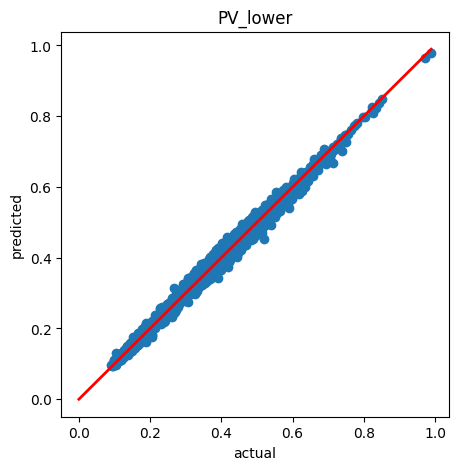

Mean Squared Error (MSE): 0.00012376640791099953
Mean Absolute Error (MAE): 0.008416958515830082
R-squared (R^2): 0.9898090682956328
Root Mean Squared Error (RMSE): 0.01112503518695557


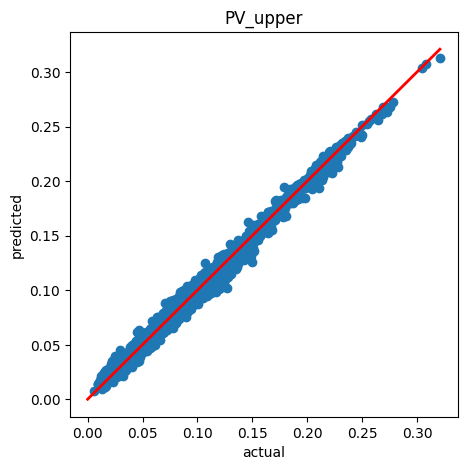

Mean Squared Error (MSE): 1.7615277212038884e-05
Mean Absolute Error (MAE): 0.0030865376118276253
R-squared (R^2): 0.9923122490282057
Root Mean Squared Error (RMSE): 0.004197055779000189


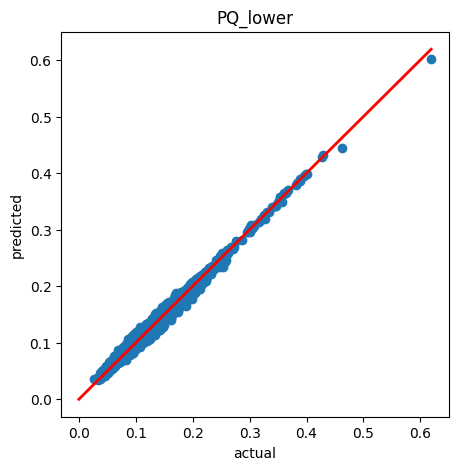

Mean Squared Error (MSE): 2.5776177300090762e-05
Mean Absolute Error (MAE): 0.003830952905676982
R-squared (R^2): 0.9870010711159718
Root Mean Squared Error (RMSE): 0.005077024453367421


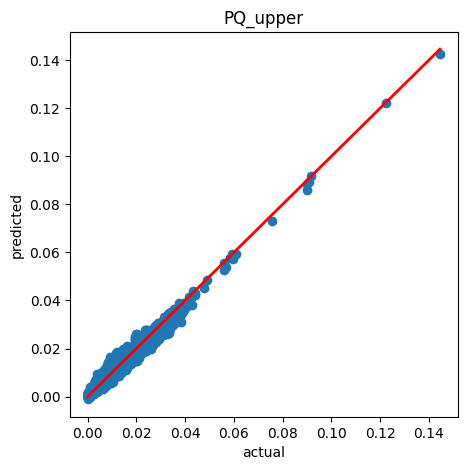

Mean Squared Error (MSE): 2.4120097445890743e-06
Mean Absolute Error (MAE): 0.0011505395853359326
R-squared (R^2): 0.9749499184565183
Root Mean Squared Error (RMSE): 0.0015530646298815365


In [15]:
if RegressorML:
    # Paso 4: Calcular las métricas de evaluación
    for idx, col in enumerate(Y_true.columns):

        plt.figure(figsize=(5,5))
        plt.scatter(Y_true.iloc[:,idx].values,y_pred[:,idx])
        plt.plot([0,Y_true.iloc[:,idx].max()], [0,Y_true.iloc[:,idx].max()], color='r',linestyle ='-', linewidth=2)
        plt.ylabel('predicted')
        plt.xlabel('actual')
        plt.title(col)
        plt.show()

        mse = mean_squared_error(Y_true.iloc[:,idx], y_pred[:,idx])
        mae = mean_absolute_error(Y_true.iloc[:,idx], y_pred[:,idx])
        r2 = r2_score(Y_true.iloc[:,idx], y_pred[:,idx])
        rmse = np.sqrt(mse)
        print('======================================')
        print("Mean Squared Error (MSE):", mse)
        print("Mean Absolute Error (MAE):", mae)
        print("R-squared (R^2):", r2)
        print("Root Mean Squared Error (RMSE):", rmse)
        print('======================================')

## Shap values

In [16]:
if shapValues:
    if Trainall:
        X_test = X_train

    if PipelineObject:
        explainer = shap.Explainer(pipeline.predict, X_train, algorithm = "permutation")
        shap_values = explainer(X_test)
        shapeshap = np.shape(shap_values.values) # We have one SHAP value for each feature in our modul
        print(f'In your case, your SHAP values have shape {shapeshap}, so you have SHAP values for multiple instances ({shapeshap[0]} instances in this case) and multiple features ({shapeshap[1]} features with {shapeshap[2]} outputs).')
    else:
        if XGB_Regressor == False:
            explainer_2 = shap.Explainer(model.predict,X_train,algorithm = "permutation")
        else:
            # explainer_2 = shap.Explainer(model.predict,X_train,algorithm = "permutation")
            explainer_2 = shap.Explainer(model,algorithm = "tree")
        shap_values_2 = explainer_2(X_test)
        shapeshap_2 = np.shape(shap_values_2.values) # We have one SHAP value for each feature in our modul
        print(f'In your case, your SHAP values have shape {shapeshap_2}, so you have SHAP values for multiple instances ({shapeshap_2[0]} instances in this case) and multiple features ({shapeshap_2[1]} features with {shapeshap_2[2]} outputs).')

In your case, your SHAP values have shape (5325, 48, 4), so you have SHAP values for multiple instances (5325 instances in this case) and multiple features (48 features with 4 outputs).


In [17]:
if shapValues:
    # Assuming shap_values is your array with shape (1346, 143, 6)
    # Selecting SHAP values for a specific instance (e.g., first instance) and output (e.g., first output)
    instance_index = 0
    # for i in range(shapeshap[2]):
    #     shap_values_instance_output = shap_values[instance_index][:, i]
    #     # Visualize waterfall plot for the selected instance and output
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.waterfall(shap_values_instance_output,max_display=10)
        
    # #Mean SHAP
    # for i in range(shapeshap[2]):
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.bar(shap_values[:,:, i],max_display=15) #Features that have made large positive/negative contributions will have a large mean SHAP value.

    # # Beeswarm plot
    # for i in range(shapeshap[2]):
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.beeswarm(shap_values[:,:, i],max_display=15)

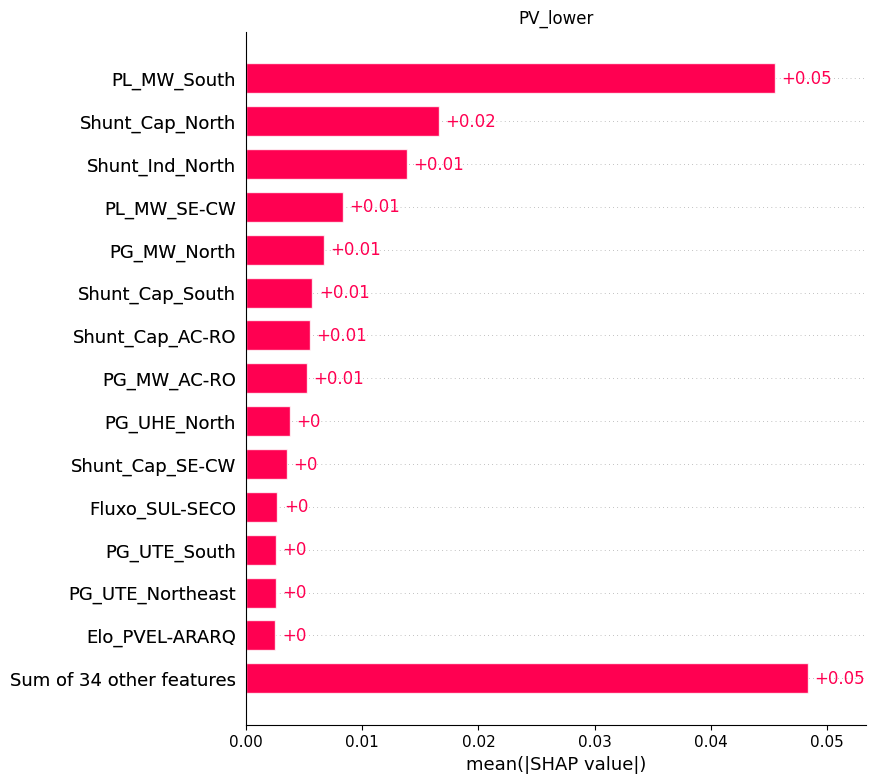

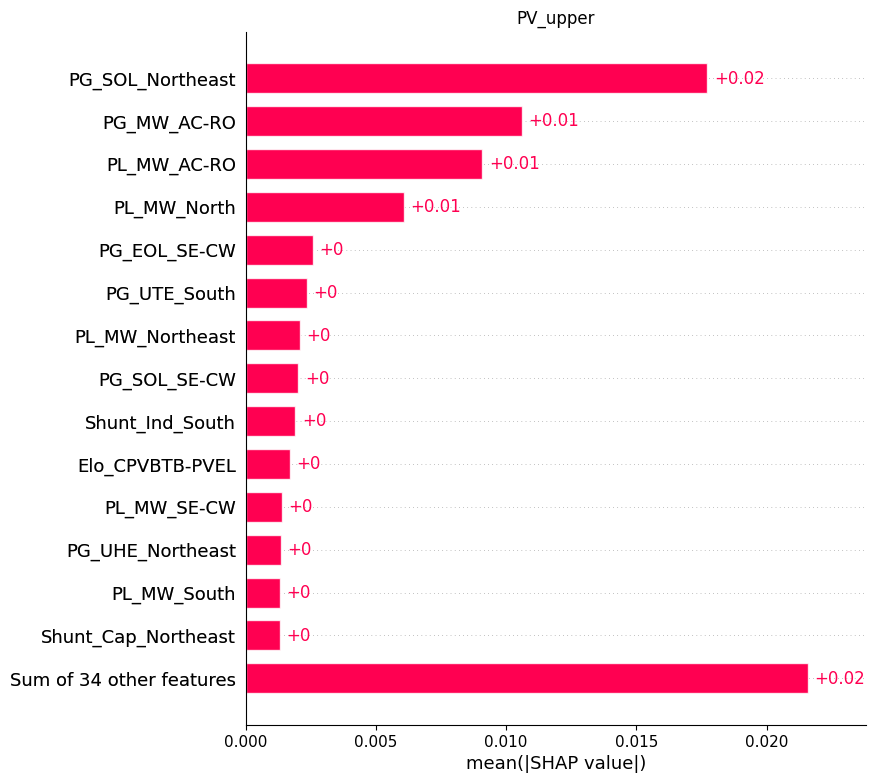

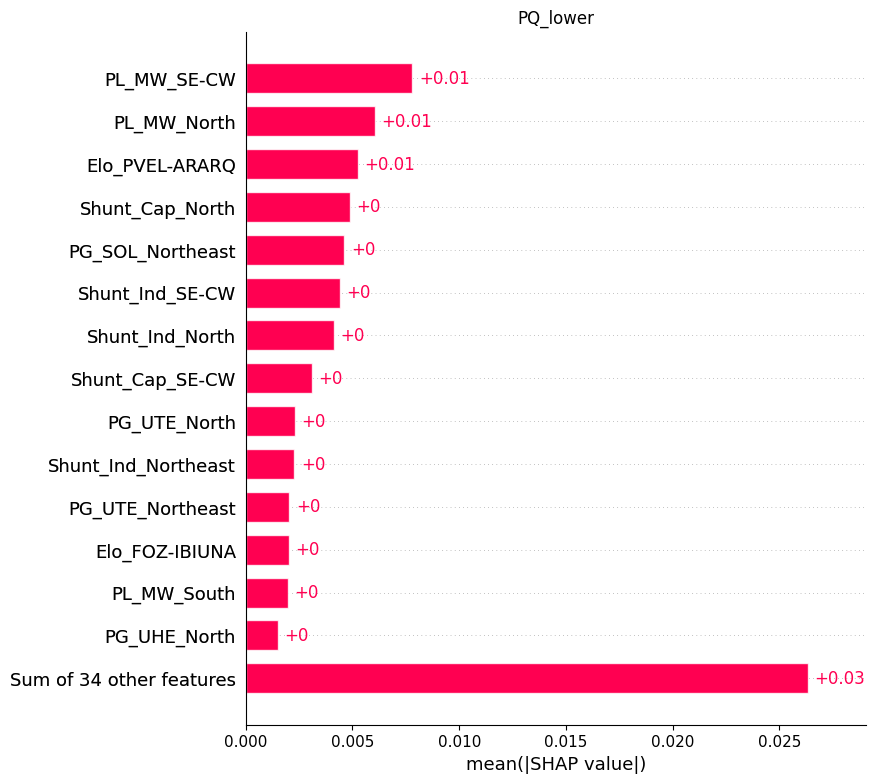

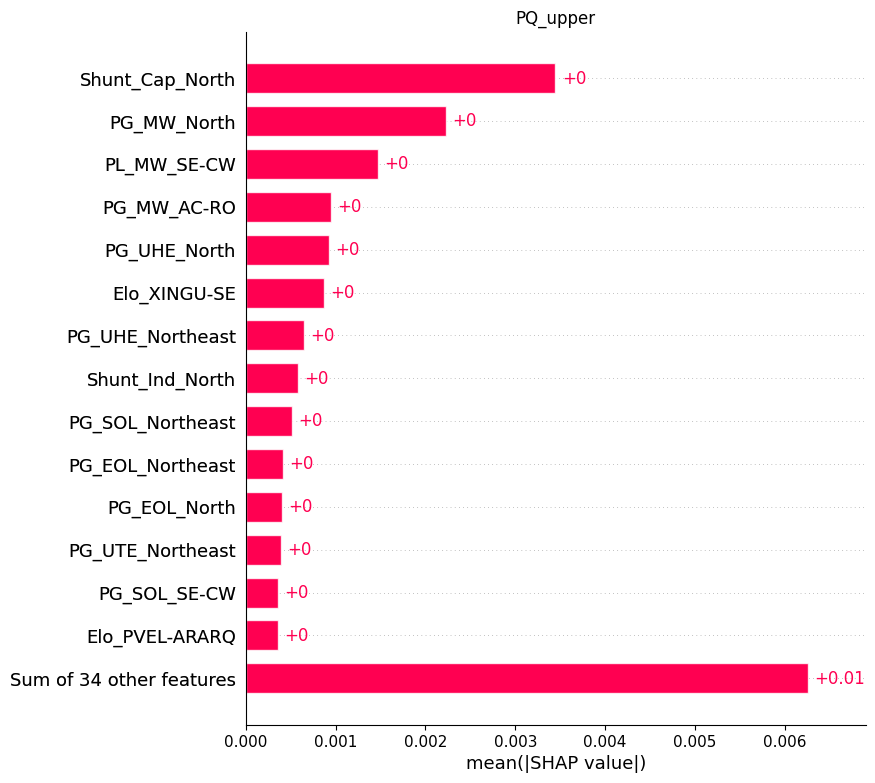

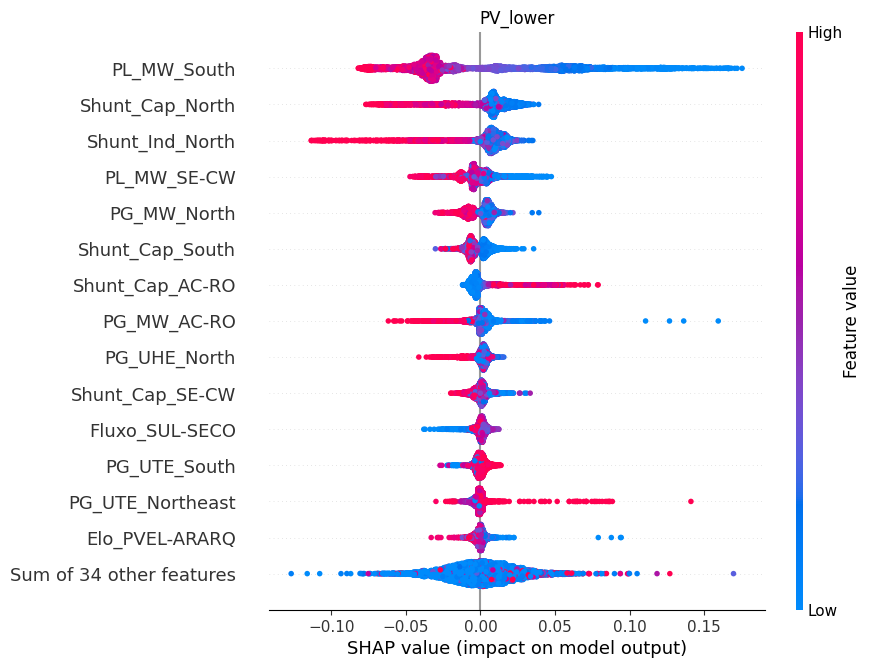

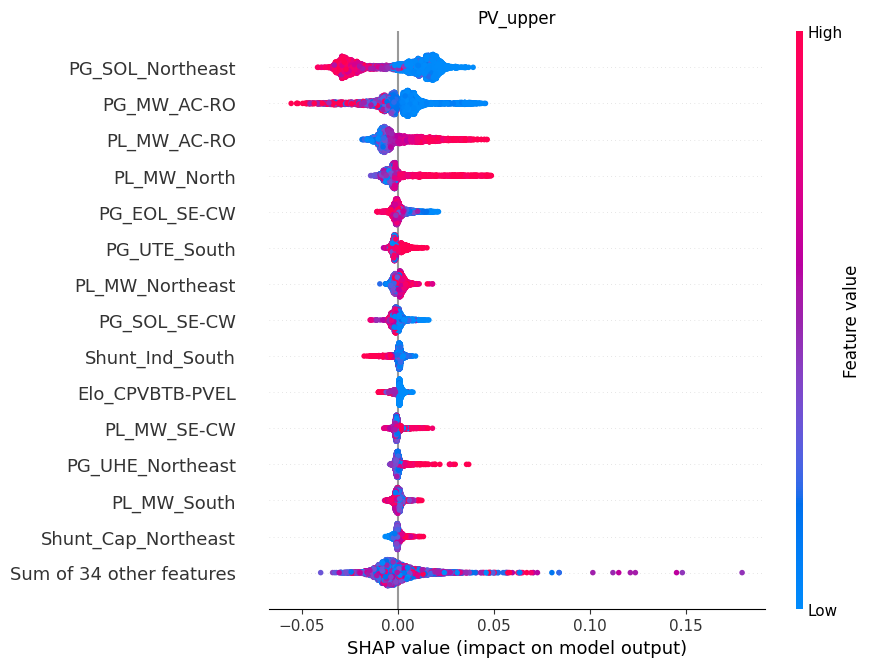

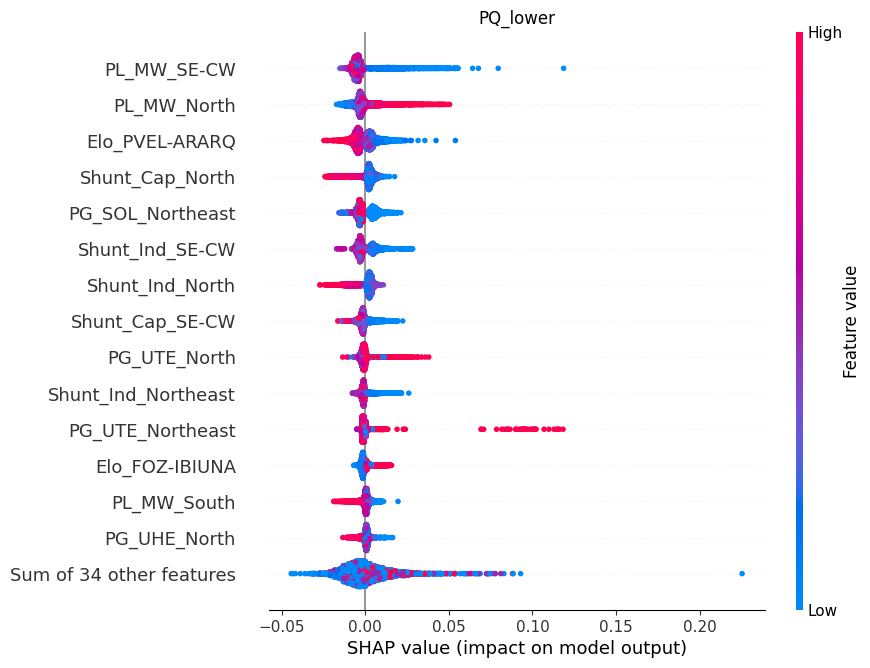

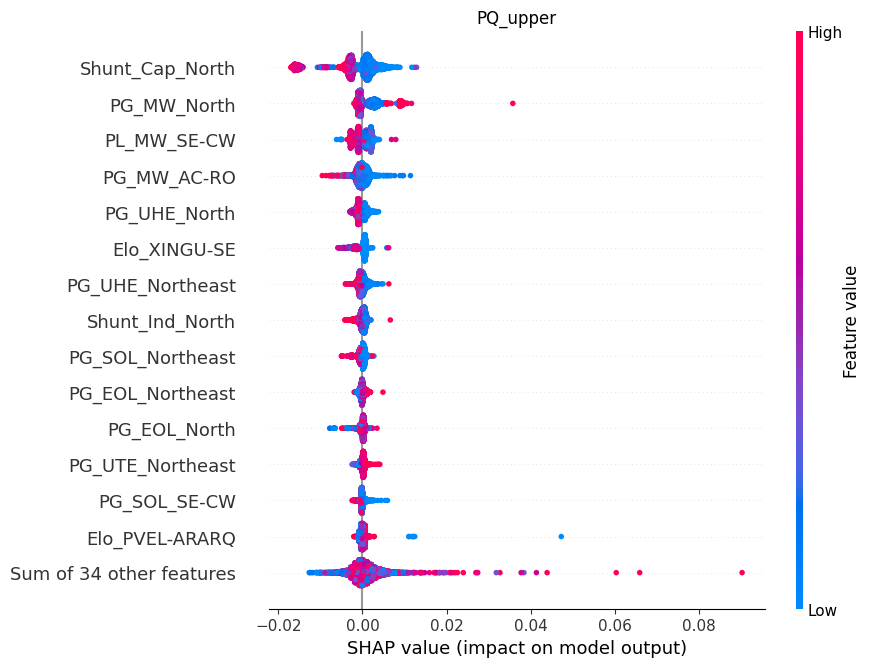

In [18]:
if shapValues:
    # Assuming shap_values is your array with shape (1346, 143, 6)
    # Selecting SHAP values for a specific instance (e.g., first instance) and output (e.g., first output)
    instance_index = 0
    # for i in range(shapeshap_2[2]):
    #     shap_values_instance_output = shap_values_2[instance_index][:, i]
    #     # Visualize waterfall plot for the selected instance and output
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.waterfall(shap_values_instance_output,max_display=10)
        
    #Mean SHAP
    for i in range(shapeshap_2[2]):
        plt.title(f'{Y.columns[i]}')
        shap.plots.bar(shap_values_2[:,:, i],max_display=15) #Features that have made large positive/negative contributions will have a large mean SHAP value.

    # Beeswarm plot
    for i in range(shapeshap_2[2]):
        plt.title(f'{Y.columns[i]}')
        shap.plots.beeswarm(shap_values_2[:,:, i],max_display=15)
    

In [22]:
shap.plots.force(shap_values_2[:100,:, 0]) # PV LOWER

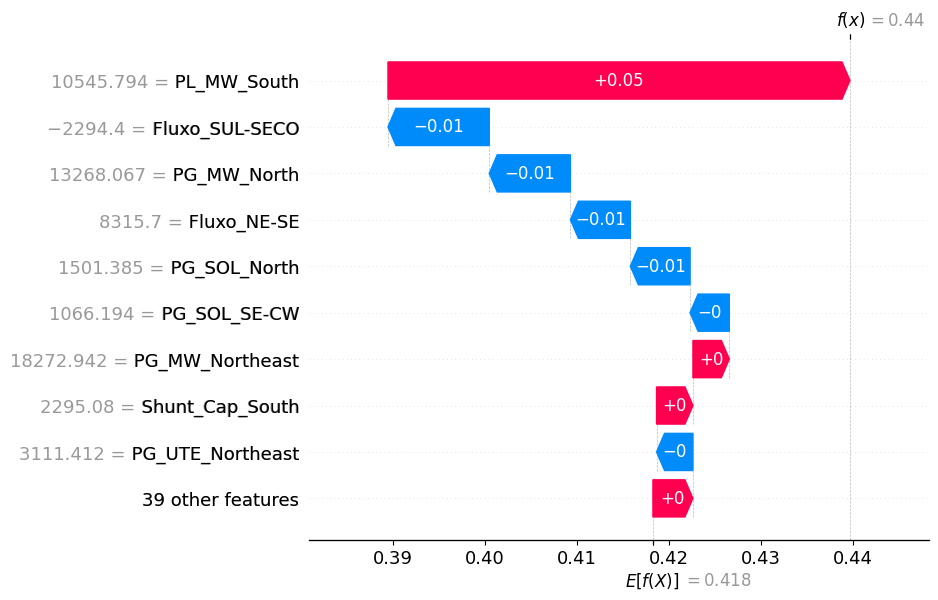

In [25]:
shap.plots.waterfall(shap_values_2[100,:, 0],max_display=10)